In [1]:
import pyodbc
from meyerDB import cable_connection
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import sklearn.preprocessing as pp
from sklearn.utils import shuffle
from scipy.optimize import curve_fit

from keras import models
from keras.layers import Dense, Dropout


# init db connection
conn = pyodbc.connect(cable_connection)
cursor = conn.cursor()
print('Database connection ok')

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            try:
                value = str(round(100*field, 1)).replace('.', ',') + '%'
            except:
                value = field
            html += "<td><h4>%s</h4><td>"%(value)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

def logifunc(x,x0,k,l):
    #l = 2300
    return l / (1 + np.exp(-k*(x - x0)))

Database connection ok


In [95]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, current total quantity, past 10 week time series
# Algorithms:
# Neural Network + linear regression

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " WHERE p.prototype=1"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
y = data[:, -1]

gtmax = gt.max()
ymax = y.max()
gt = gt/gtmax
y = y/ymax

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()

# train and evaluate
accuracies = []
r = 0
start = -80
window = 10
for train_i, test_i in lpo.split(y):
    r += 1
    if not (r % 1) == 0:
        continue
    X_train = []
    y_train = []

    linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])
    # train
    for i in train_i:
        ship = ships[i]
        step = 1
        for wk in range(start, 1, step):
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk > {} AND wk <= {} AND project_id={}"
                .format(wk - window, wk, ship)
            )
            data = np.array(cursor.fetchall())/ymax
            features = [data[0][0]]#list(data[:, 0])
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk <= {} AND project_id={}"
                .format(wk, ship)
            )
            current_sum = cursor.fetchall()[0][0]/ymax
            features.append(current_sum)
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            #features.append(linear_pred)
            features.append(wk/100.0)
            X_train.append(features)
            y_train.append(y[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    # define model
    model = models.Sequential()
    model.add(Dense(64, activation='sigmoid', input_shape=(3,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(12, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['accuracy'])

    # Train model
    model.fit(X_train, y_train,
            batch_size=20,
            epochs=500,
            verbose=0)

    # evaluate
    step = 1
    x = []
    acc_func = []
    sums = []
    for wk in range(start, 1, step):
        X_test = []
        y_test = []
        for i in test_i:
            ship = ships[i]
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk > {} AND wk <= {} AND project_id={}"
                .format(wk - window, wk, ship)
            )
            data = np.array(cursor.fetchall())/ymax
            features = [data[0][0]]#list(data[:, 0])
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk <= {} AND project_id={}"
                .format(wk, ship)
            )
            current_sum = cursor.fetchall()[0][0]/ymax
            features.append(current_sum)
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            #features.append(linear_pred)
            features.append(wk/100.0)
            X_test.append(features)
            y_test.append(y[i])
        sums.append(current_sum)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        #get current progress
        cursor.execute(
            "SELECT"
            " sum(CASE WHEN wk <= {} THEN cables ELSE 0.0 END),"
            " sum(cast(cables as float))"
            " FROM progress WHERE project_id={}"
            .format(wk, ship)
        )
        progress = wk#cursor.fetchall()[0][0]

        preds = model.predict(X_test)
        #preds = linearModel.predict(X_test)
        y_true = y_test
        acc = 100*(1-mape(y_true, preds))
        x.append(progress)
        acc_func.append(acc)
    accuracies.append(acc_func)


accuracies = np.array(accuracies)
mean_acc_func = accuracies.mean(axis=0)
plt.plot(x, mean_acc_func)
plt.ylim([50, 100])
plt.show()

            

KeyboardInterrupt: 

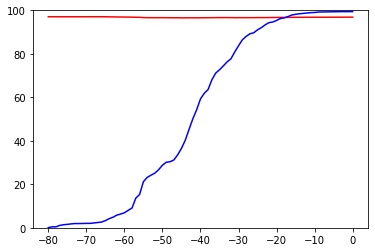

In [28]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, current total quantity, past 10 week time series
# Algorithms:
# Neural Network + linear regression

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
y = data[:, -1]

gtmax = gt.max()
ymax = y.max()
gt = gt/gtmax
y = y/ymax

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()

# train and evaluate
accuracies = []
accuracies2 = []
r = 0
start = -80
window = 20
for train_i, test_i in lpo.split(y):
    r += 1
    if not (r % 20) == 0:
        continue
    X_train = []
    y_train = []

    linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])
    # train
    for i in train_i:
        ship = ships[i]
        step = 1
        for wk in range(start, 1, step):
            cursor.execute(
                "SELECT cables FROM progress WHERE"
                " wk > {} AND wk <= {} AND project_id={}"
                .format(wk - window, wk, ship)
            )
            data = np.array(cursor.fetchall())/ymax
            #features = list(data[:, 0])
            x2 = range(0, window)
            [k, b] = np.polyfit(x2, data[:, 0], 1)
            features = [k]
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk <= {} AND project_id={}"
                .format(wk, ship)
            )
            current_sum = cursor.fetchall()[0][0]/ymax
            features.append(current_sum)
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            features.append(linear_pred)
            features.append(wk/100.0)
            X_train.append(features)
            y_train.append(y[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    # define model
    model = models.Sequential()
    model.add(Dense(64, activation='sigmoid', input_shape=(4,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(12, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['accuracy'])

    # Train model
    model.fit(X_train, y_train,
            batch_size=20,
            epochs=3000,
            verbose=0)

    # evaluate
    step = 1
    x = []
    acc_func = []
    acc_func2 = []
    sums = []
    
    for wk in range(start, 1, step):
        X_test = []
        y_test = []
        preds2 = []
        for i in test_i:
            ship = ships[i]
            cursor.execute(
                "SELECT cables FROM progress WHERE"
                " wk > {} AND wk <= {} AND project_id={}"
                .format(wk - window, wk, ship)
            )
            data = np.array(cursor.fetchall())/ymax
            #features = list(data[:, 0])
            x2 = range(0, window)
            [k, b] = np.polyfit(x2, data[:, 0], 1)
            features = [k]
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk <= {} AND project_id={}"
                .format(wk, ship)
            )
            current_sum = cursor.fetchall()[0][0]/ymax
            features.append(current_sum)
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            features.append(linear_pred)
            features.append(wk/100.0)
            X_test.append(features)
            y_test.append(y[i])
            preds2.append(current_sum)
        sums.append(current_sum)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        #get current progress
        cursor.execute(
            "SELECT"
            " sum(CASE WHEN wk <= {} THEN cables ELSE 0.0 END),"
            " sum(cast(cables as float))"
            " FROM progress WHERE project_id={}"
            .format(wk, ship)
        )
        progress = wk#cursor.fetchall()[0][0]

        preds = model.predict(X_test)
        y_true = y_test
        acc = 100*(1-mape(y_true, preds))
        x.append(progress)
        acc_func.append(acc)
        acc2 = 100*(1-mape(y_true, preds2))
        acc_func2.append(acc2)
    accuracies.append(acc_func)
    accuracies2.append(acc_func2)

accuracies = np.array(accuracies)
mean_acc_func = accuracies.mean(axis=0)
accuracies2 = np.array(accuracies2)
mean_acc_func2 = accuracies2.mean(axis=0)
plt.plot(x, mean_acc_func, 'r')
plt.plot(x, mean_acc_func2, 'b')
plt.ylim([0, 100])
plt.show()

            

C:\Users\sainmi53\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\sainmi53\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\sainmi53\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\sainmi53\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\sainmi5

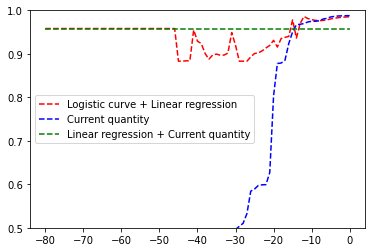

In [6]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, current total quantity, past 10 week time series
# Algorithms:
# Logistic curve regression + Linear Regression

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, prototype, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " WHERE r.project_id<>1392"
    " GROUP BY r.project_id, gross_tonnage, prototype")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
pt = data[:, 2]
y = data[:, -1]

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()

# train and evaluate

for start in [-16, -80]:
    r = 0
    for train_i, test_i in lpo.split(y):
        if pt[test_i].sum() < 2:
            pass
        accuracies = []
        accuracies2 = []
        accuracies3 = []
        r += 1
        if not (r % 1) == 0:
            continue
        linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])

        # evaluate
        step = 1
        x = []
        acc_func = []
        acc_func2 = []
        acc_func3 = []
        sums = []
        for wk in range(start, 1, step):
            y_test = []
            preds = []
            preds2 = []
            preds3 = []
            for i in test_i:
                ship = ships[i]
                linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
                cursor.execute(
                    "SELECT wk, cables FROM progress WHERE"
                    " wk <= {} AND project_id={} ORDER BY wk"
                    .format(wk, ship)
                )
                data = np.array(cursor.fetchall())
                sequence = data[:, -1].cumsum()
                xseq = data[:, 0]
                lim = (linear_pred*0.5)
                if sequence[-1] >= lim:
                    cut = np.argmax(sequence > lim)
                    sequence = sequence[cut:]
                    xseq = xseq[cut:]
                    
                    scaler = 0.15
                    low = linear_pred - (linear_pred*scaler)
                    if sequence[-1] > low:
                        low = sequence[-1]
                    high = linear_pred + (linear_pred*scaler)
                    if low > high:
                        high = low + (low*scaler)
                    (x0hat, khat, lhat), _ = curve_fit(logifunc, xseq, sequence, bounds=([-100, 0, low], [0, 0.5, high]))
                    preds.append(lhat)
                else:
                    preds.append(linear_pred)
                preds2.append(sequence[-1])
                if sequence[-1]>linear_pred:# abs(sequence[-1]-linear_pred)/linear_pred < 0.2:
                    preds3.append(sequence[-1])
                else:
                    preds3.append(linear_pred)
                y_test.append(y[i])
                if False:
                    plt.plot(xseq, sequence)
                    plt.plot(xseq, logifunc(xseq, x0hat, khat, lhat))
                    plt.show()
                    input('pause')


            y_true = y_test
            acc = (1-mape(y_true, preds))
            acc_func.append(acc)
            acc = (1-mape(y_true, preds2))
            acc_func2.append(acc)
            acc = (1-mape(y_true, preds3))
            acc_func3.append(acc)
            x.append(wk)
        accuracies.append(acc_func)
        accuracies2.append(acc_func2)
        accuracies3.append(acc_func3)


    accuracies = np.array(accuracies)
    mean_acc_func = accuracies.mean(axis=0)
    accuracies2 = np.array(accuracies2)
    mean_acc_func2 = accuracies2.mean(axis=0) 
    accuracies3 = np.array(accuracies3)
    mean_acc_func3 = accuracies3.mean(axis=0)
    table_rows = [['Model', 'mean (from {} weeks to delivery)'.format(abs(start))]]
    table_rows.append(['Logistic curve + Linear regression', mean_acc_func.mean()])
    table_rows.append(['Current quantity', mean_acc_func2.mean()])
    table_rows.append(['Linear regression + Current quantity', mean_acc_func3.mean()])
    display_table(table_rows)


plt.plot(x, mean_acc_func, 'r--')
plt.plot(x, mean_acc_func2, 'b--')
plt.plot(x, mean_acc_func3, 'g--')
plt.ylim([0.5, 1])
plt.legend(['Logistic curve + Linear regression', 'Current quantity', 'Linear regression + Current quantity'])
plt.show()

            